In [1]:
from pathlib import Path
from glob import glob
import pickle
import matplotlib.pyplot as plt
from ravens.utils import utils
import cv2
import numpy as np
import os
import pybullet as p
import plotly.express as px

2022-07-04 12:39:13.774238: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
pybullet build time: May 20 2022 19:43:01


# Generate TableTop from SIm Files

## Load Camera Calibration

In [2]:
cam_config=[{'image_size': (480, 640), 
             'intrinsics': np.array((450.0, 0, 320.0,
                            0, 450.0, 240.0,
                            0, 0, 1)).reshape(3, 3), 
             'position': np.array((1.0, 0, 0.75)).reshape(3, 1), 
             'rotation': np.array(p.getMatrixFromQuaternion((0.6532814824381883, 0.6532814824381884, 
                          -0.2705980500730986, -0.27059805007309845))).reshape(3, 3), 
             'zrange': (0.01, 10.0), 'noise': False}, 
            ]
bounds = np.array([[ 0.25,  0.75],
       [-0.5 ,  0.5 ],
       [ 0.  ,  0.28]])
pix_size = 0.003125

In [3]:
cam_config

[{'image_size': (480, 640),
  'intrinsics': array([[450.,   0., 320.],
         [  0., 450., 240.],
         [  0.,   0.,   1.]]),
  'position': array([[1.  ],
         [0.  ],
         [0.75]]),
  'rotation': array([[-2.22044605e-16,  7.07106781e-01, -7.07106781e-01],
         [ 1.00000000e+00,  0.00000000e+00, -2.77555756e-16],
         [-1.11022302e-16, -7.07106781e-01, -7.07106781e-01]]),
  'zrange': (0.01, 10.0),
  'noise': False}]

## Load Images and Depths

In [5]:
ravens_path=Path("/home/robo/ravens")
task_path=Path(ravens_path/"block-insertion-train")
color_path = task_path/"color"
depth_path= task_path/"depth"

color_files=glob(str(color_path/"*.pkl"))
depth_files=glob(str(depth_path/"*.pkl"))

images = []
depths = []
images.append(pickle.load(open(color_files[0],"rb"))[0,0])
depths.append(pickle.load(open(depth_files[0],"rb"))[0,0])

In [6]:
depths[0].min(),depths[0].max()

(0.47008908, 2.2700627)

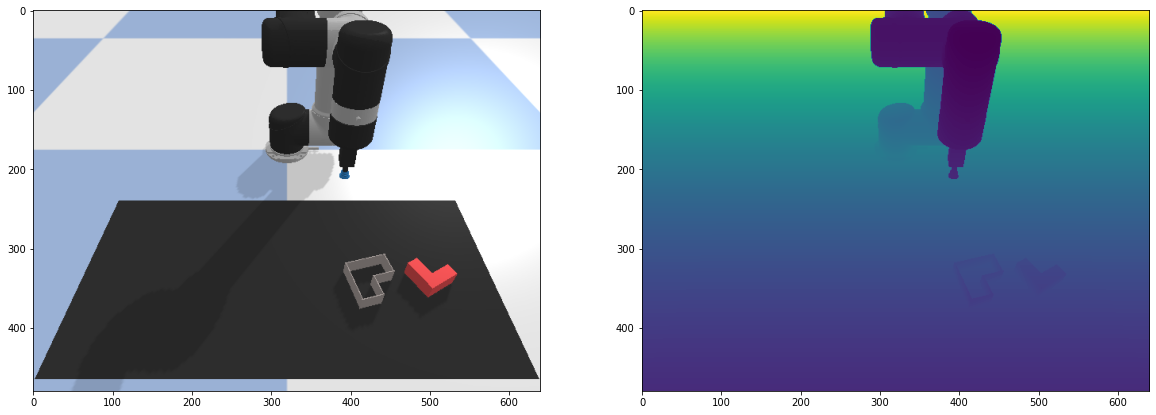

In [7]:
f,ax = plt.subplots(figsize=(20,10),ncols=2,nrows=1)
ax = ax.flatten()
ax[0].imshow(images[0])
ax[1].imshow(depths[0])
plt.show()

In [8]:
np.array(depths).shape

(1, 480, 640)

(320, 160, 3) (320, 160)


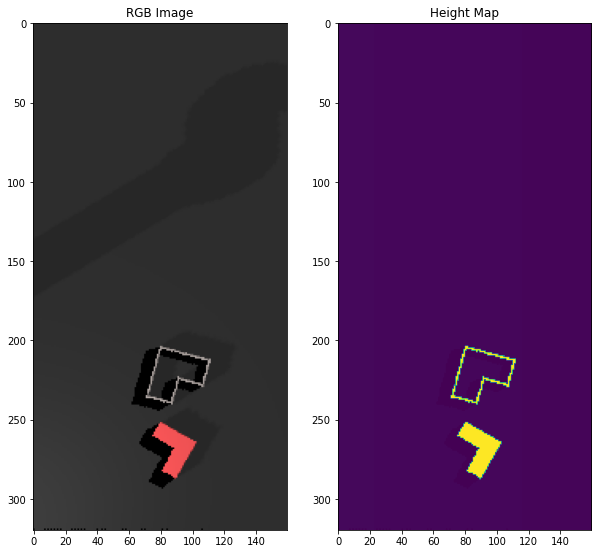

In [9]:
obs = {"color":np.array(images), "depth":np.array(depths)}

cmap, hmap = utils.get_fused_heightmap(obs, cam_config, bounds, pix_size,reshape_translation=False, reshape_intrinsics=False,
                                       reshape_rotation=False)
print(cmap.shape, hmap.shape)
f,ax = plt.subplots(figsize=(10,10),ncols=2,nrows=1)
ax[0].imshow(cmap)
ax[0].set_title("RGB Image")
ax[1].set_title("Height Map")
ax[1].imshow(hmap)

## Generate PointCloud

(480, 640, 3)


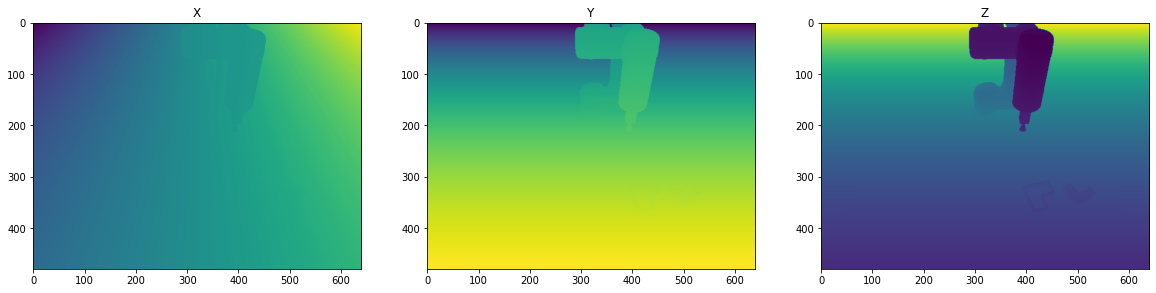

In [10]:
idx=0
camera = cam_config[idx]
depth = depths[idx]
color = images[idx]
xyz = utils.get_pointcloud(depth, camera["intrinsics"])
print(xyz.shape)
f,ax = plt.subplots(figsize=(20,10),ncols=3)
ax = ax.flatten()
ax[0].imshow(xyz[:,:,0])
ax[0].set_title("X")
ax[1].imshow(xyz[:,:,1])
ax[1].set_title("Y")
ax[2].imshow(xyz[:,:,2])
ax[2].set_title("Z")
plt.show()

## Transform PointCloud

(480, 640, 3)


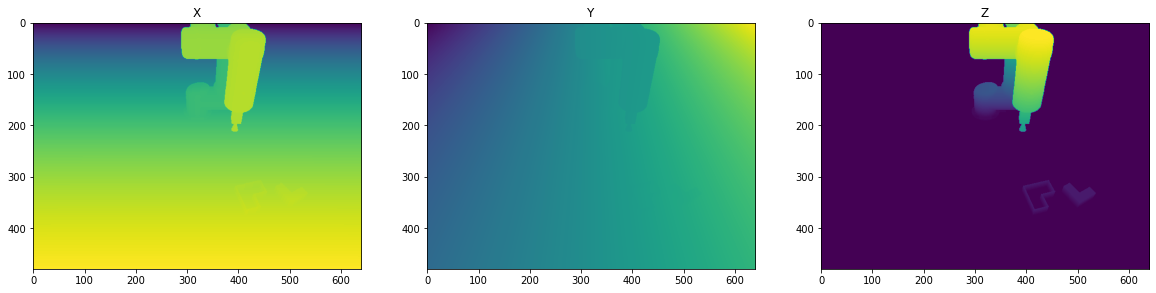

In [11]:
transform = np.eye(4)
transform[:3, :] = np.hstack((camera["rotation"], camera["position"]))
xyz_trans = utils.transform_pointcloud(xyz, transform)
print(xyz_trans.shape)
f,ax = plt.subplots(figsize=(20,10),ncols=3)
ax = ax.flatten()
ax[0].imshow(xyz_trans[:,:,0])
ax[0].set_title("X")
ax[1].imshow(xyz_trans[:,:,1])
ax[1].set_title("Y")
ax[2].imshow(xyz_trans[:,:,2])
ax[2].set_title("Z")
plt.show()

In [ ]:
fig = px.imshow(xyz_trans[:,:,0])
fig.show()

In [ ]:
fig = px.imshow(xyz_trans[:,:,1])
fig.show()

In [ ]:
fig = px.imshow(xyz_trans[:,:,2])
fig.show()

In [ ]:
xyz_trans.min(), xyz_trans.max()

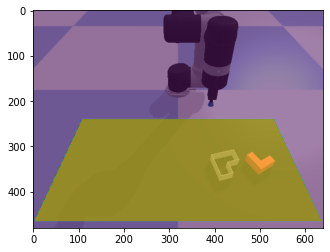

In [12]:
ix = (xyz_trans[Ellipsis, 0] >= bounds[0, 0]) & (xyz_trans[Ellipsis, 0] < bounds[0, 1])
iy = (xyz_trans[Ellipsis, 1] >= bounds[1, 0]) & (xyz_trans[Ellipsis, 1] < bounds[1, 1])
iz = (xyz_trans[Ellipsis, 2] >= bounds[2, 0]) & (xyz_trans[Ellipsis, 2] < bounds[2, 1])
valid = ix & iy & iz

plt.imshow(valid)
plt.imshow(color, alpha=0.5)
plt.show()

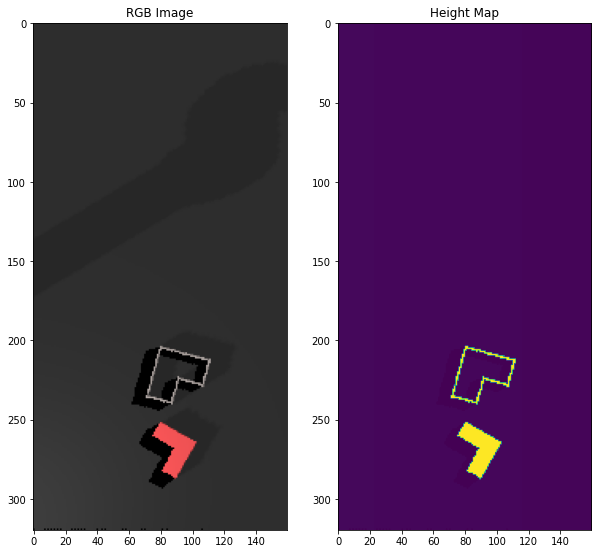

In [13]:
heightmap, colormap = utils.get_heightmap(xyz, color, bounds, pix_size)
f,ax = plt.subplots(figsize=(10,10),ncols=2,nrows=1)
ax[0].imshow(colormap)
ax[0].set_title("RGB Image")
ax[1].set_title("Height Map")
ax[1].imshow(heightmap)